In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

import cv2
import os
import glob

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import recall_score

In [2]:
# Input data files are available in the "../input/" directory.
INPUT_PATH = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# List the files in the input directory.
print(os.listdir(INPUT_PATH))

['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [3]:
# list of all the training images
train_normal = Path(INPUT_PATH + '/train/NORMAL').glob('*.jpeg')
train_pneumonia = Path(INPUT_PATH + '/train/PNEUMONIA').glob('*.jpeg')

# ---------------------------------------------------------------
# Train data format in (img_path, label) 
# Labels for [ the normal cases = 0 ] & [the pneumonia cases = 1]
# ---------------------------------------------------------------
normal_data = [(image, 0) for image in train_normal]
pneumonia_data = [(image, 1) for image in train_pneumonia]

train_data = normal_data + pneumonia_data

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'])

# Checking the dataframe...
train_data.head()

,image,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0


In [4]:
# Checking the dataframe...
train_data.tail()

,image,label
5211,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
5212,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
5213,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
5214,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
5215,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


In [5]:
# Shuffle the data 
train_data = train_data.sample(frac=1., random_state=100).reset_index(drop=True)

# Checking the dataframe...
train_data.head(10)

,image,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


In [6]:
print(train_data)

                                                  image  label
0     /kaggle/input/chest-xray-pneumonia/chest_xray/...      1
1     /kaggle/input/chest-xray-pneumonia/chest_xray/...      1
2     /kaggle/input/chest-xray-pneumonia/chest_xray/...      1
3     /kaggle/input/chest-xray-pneumonia/chest_xray/...      1
4     /kaggle/input/chest-xray-pneumonia/chest_xray/...      1
...                                                 ...    ...
5211  /kaggle/input/chest-xray-pneumonia/chest_xray/...      1
5212  /kaggle/input/chest-xray-pneumonia/chest_xray/...      1
5213  /kaggle/input/chest-xray-pneumonia/chest_xray/...      0
5214  /kaggle/input/chest-xray-pneumonia/chest_xray/...      0
5215  /kaggle/input/chest-xray-pneumonia/chest_xray/...      1

[5216 rows x 2 columns]


Total of Train Data :  5216   (0 : Normal; 1 : Pneumonia)
label
1    3875
0    1341
Name: count, dtype: int64


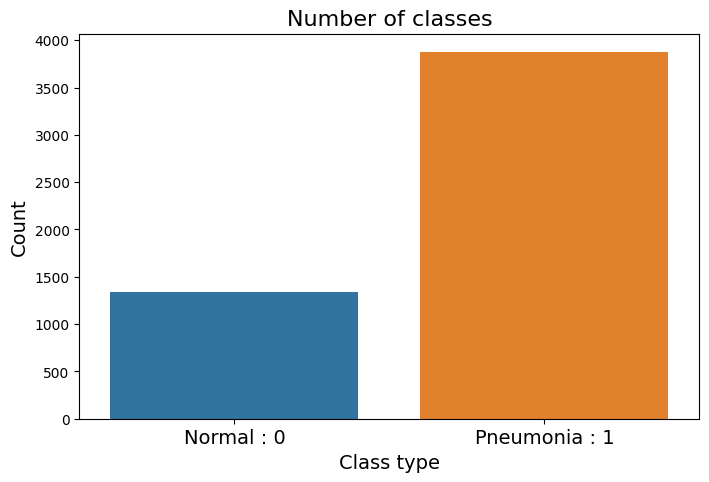

In [7]:
# Counts for both classes
count_result = train_data['label'].value_counts()
print('Total of Train Data : ', len(train_data), '  (0 : Normal; 1 : Pneumonia)')
print(count_result)

# Plot the results 
plt.figure(figsize=(8,5))
sns.countplot(x = 'label', data =  train_data)
plt.title('Number of classes', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)), 
           ['Normal : 0', 'Pneumonia : 1'], 
           fontsize=14)
plt.show()

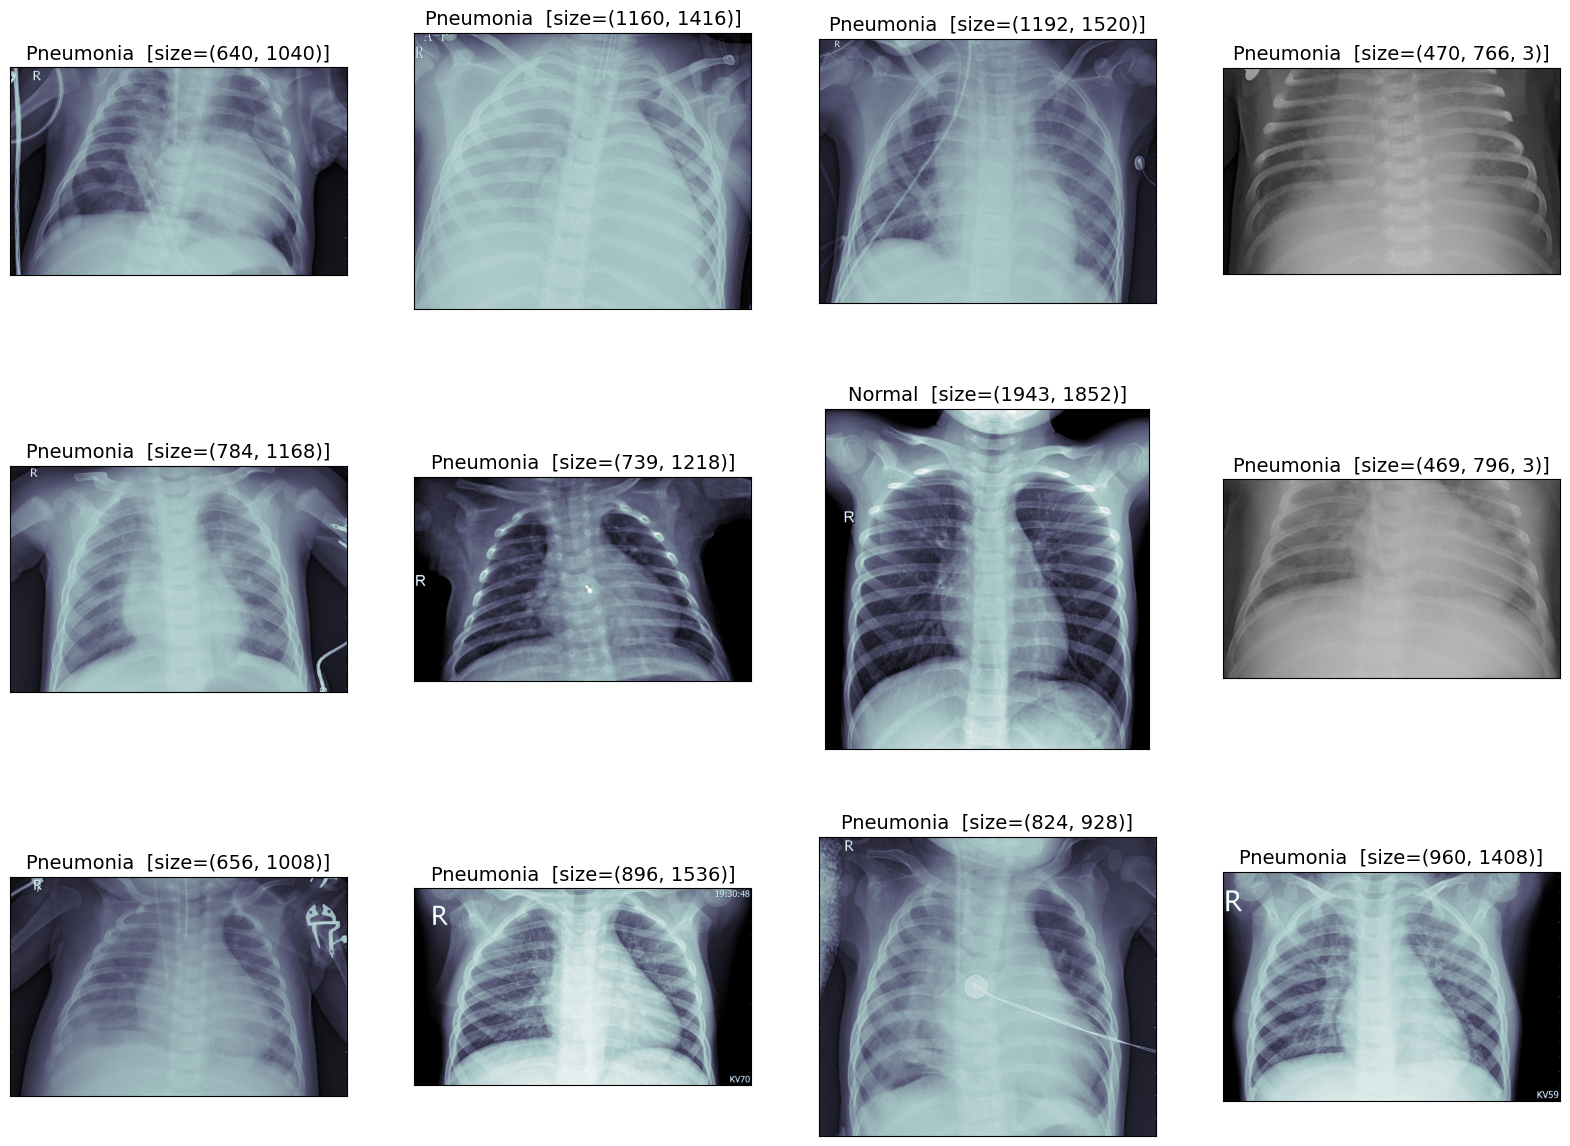

In [8]:
fig, ax = plt.subplots(3, 4, figsize=(20,15))
for i, axi in enumerate(ax.flat):
    image = imread(train_data.image[i])
    axi.imshow(image, cmap='bone')
    axi.set_title(('Normal' if train_data.label[i] == 0 else 'Pneumonia') 
                  + '  [size=' + str(image.shape) +']',
                  fontsize=14)
    axi.set(xticks=[], yticks=[])

In [9]:
train_data.to_numpy().shape

(5216, 2)

In [10]:
# ----------------------------------------------------------------------
#  Loading X-ray Images datasets from file 3 directories, respectively. 
# ----------------------------------------------------------------------
def load_data(files_dir='/train'):
    # list of the paths of all the image files
    normal = Path(INPUT_PATH + files_dir + '/NORMAL').glob('*.jpeg')
    pneumonia = Path(INPUT_PATH + files_dir + '/PNEUMONIA').glob('*.jpeg')

    # --------------------------------------------------------------
    # Data-paths' format in (img_path, label) 
    # labels : for [ Normal cases = 0 ] & [ Pneumonia cases = 1 ]
    # --------------------------------------------------------------
    normal_data = [(image, 0) for image in normal]
    pneumonia_data = [(image, 1) for image in pneumonia]

    image_data = normal_data + pneumonia_data

    # Get a pandas dataframe for the data paths 
    image_data = pd.DataFrame(image_data, columns=['image', 'label'])
    
    # Shuffle the data 
    image_data = image_data.sample(frac=1., random_state=100).reset_index(drop=True)
    
    # Importing both image & label datasets...
    x_images, y_labels = ([data_input(image_data.iloc[i][:]) for i in range(len(image_data))], 
                         [image_data.iloc[i][1] for i in range(len(image_data))])

    # Convert the list into numpy arrays
    x_images = np.array(x_images)
    y_labels = np.array(y_labels)
    
    print("Total number of images: ", x_images.shape)
    print("Total number of labels: ", y_labels.shape)
    
    return x_images, y_labels

In [11]:
# ---------------------------------------------------------
#  1. Resizing all the images to 224x224 with 3 channels.
#  2. Then, normalize the pixel values.  
# ---------------------------------------------------------
def data_input(dataset):
    # print(dataset.shape)
    for image_file in dataset:
        image = cv2.imread(str(image_file))
        image = cv2.resize(image, (224,224))
        if image.shape[2] == 1:
            # np.dstack(): Stack arrays in sequence depth-wise 
            #              (along third axis).
            # https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html
            image = np.dstack([image, image, image])
        
        # ----------------------------------------------------------
        # cv2.cvtColor(): The function converts an input image 
        #                 from one color space to another. 
        # [Ref.1]: "cvtColor - OpenCV Documentation"
        #     - https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html
        # [Ref.2]: "Python計算機視覺編程- 第十章 OpenCV" 
        #     - https://yongyuan.name/pcvwithpython/chapter10.html
        # ----------------------------------------------------------
        x_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Normalization
        x_image = x_image.astype(np.float32)/255.
        return x_image

### Importing Training Datasets

In [12]:
# Import train dataset...
x_train, y_train = load_data(files_dir='/train')

print(x_train.shape)
print(y_train.shape)

Total number of images:  (5216, 224, 224, 3)
Total number of labels:  (5216,)
(5216, 224, 224, 3)
(5216,)


In [13]:
x_train[0].shape

(224, 224, 3)

In [14]:
x_train[0]

array([[[0.26666668, 0.26666668, 0.26666668],
        [0.43529412, 0.43529412, 0.43529412],
        [0.5803922 , 0.5803922 , 0.5803922 ],
        ...,
        [0.14901961, 0.14901961, 0.14901961],
        [0.15294118, 0.15294118, 0.15294118],
        [0.08627451, 0.08627451, 0.08627451]],

       [[0.46666667, 0.46666667, 0.46666667],
        [0.26666668, 0.26666668, 0.26666668],
        [0.5372549 , 0.5372549 , 0.5372549 ],
        ...,
        [0.14117648, 0.14117648, 0.14117648],
        [0.15294118, 0.15294118, 0.15294118],
        [0.1254902 , 0.1254902 , 0.1254902 ]],

       [[0.24705882, 0.24705882, 0.24705882],
        [0.14901961, 0.14901961, 0.14901961],
        [0.54509807, 0.54509807, 0.54509807],
        ...,
        [0.12941177, 0.12941177, 0.12941177],
        [0.13333334, 0.13333334, 0.13333334],
        [0.13333334, 0.13333334, 0.13333334]],

       ...,

       [[0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        [0.05490196, 0

In [15]:
y_train

array([1, 1, 1, ..., 0, 0, 1])

### Importing Validation Datasets

In [16]:
# Import validation dataset...
x_val, y_val = load_data(files_dir='/val')

print(x_val.shape)
print(y_val.shape)

Total number of images:  (16, 224, 224, 3)
Total number of labels:  (16,)
(16, 224, 224, 3)
(16,)


In [17]:
y_val

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1])

### Importing Test Datasets

In [18]:
# Import test dataset...
x_test, y_test = load_data(files_dir='/test')

print(x_test.shape)
print(y_test.shape)


Total number of images:  (624, 224, 224, 3)
Total number of labels:  (624,)
(624, 224, 224, 3)
(624,)


In [19]:
# Counts for both classes
count_result = pd.Series(y_test).value_counts()
print('Total of Test Data : ', len(y_test), '  (0 : Normal; 1 : Pneumonia)')
print('------------------')
print(count_result)
print('------------------')
print('1 :  ', count_result[1]/sum(count_result))
print('0 :  ', count_result[0]/sum(count_result))

Total of Test Data :  624   (0 : Normal; 1 : Pneumonia)
------------------
1    390
0    234
Name: count, dtype: int64
------------------
1 :   0.625
0 :   0.375


In [20]:
y_test[:10]

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

In [21]:
# Reshape the image data to be 1D vectors
x_train_reshape = x_train.reshape(x_train.shape[0], -1)

# KNN model

In [22]:
# Split the data into training and testing sets
#x_train_knn, x_test_knn, y_train_knn, y_test_knn = train_test_split(
   # x_train_reshape, y_train, test_size=0.2, random_state=42)

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(x_train_reshape, y_train)

KNeighborsClassifier(n_neighbors=1)

In [24]:
x_val, y_val = load_data(files_dir='/val')
x_val_reshape = x_val.reshape(x_val.shape[0], -1)

Total number of images:  (16, 224, 224, 3)
Total number of labels:  (16,)


In [25]:
y_pred_val = knn_model.predict(x_val_reshape)

In [26]:
accuracy_val = accuracy_score(y_val, y_pred_val)
conf_matrix_val = confusion_matrix(y_val, y_pred_val)
classification_rep_val = classification_report(y_val, y_pred_val)
print("Validation:")
print(f"Accuracy: {accuracy_val}")
print("Confusion Matrix:")
print(conf_matrix_val)


Validation:
Accuracy: 0.5
Confusion Matrix:
[[0 8]
 [0 8]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Load test dataset
x_test, y_test = load_data(files_dir='/test')

Total number of images:  (624, 224, 224, 3)
Total number of labels:  (624,)


In [28]:
x_test_reshape = x_test.reshape(x_test.shape[0], -1)

In [29]:
y_pred_test = knn_model.predict(x_test_reshape)

[[ 89 145]
 [  8 382]]


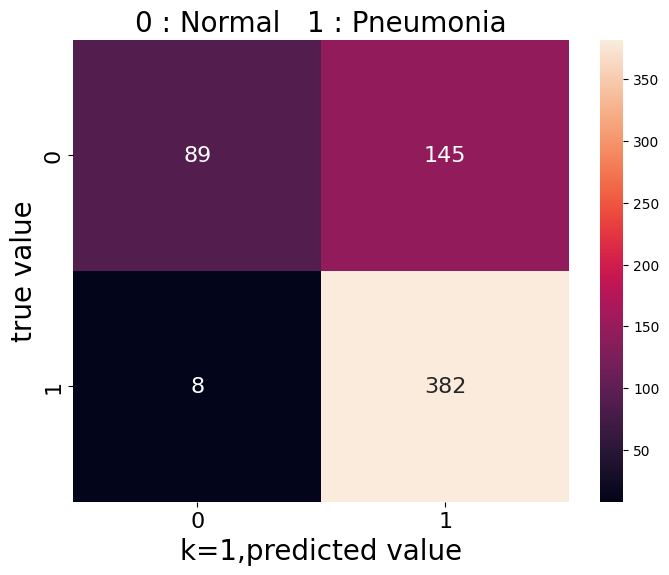

In [30]:
conf_matrix_test = confusion_matrix(y_test,y_pred_test)
print(conf_matrix_test)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_test, square=False, annot=True, fmt ='d', cbar=True, annot_kws={"size": 16})
plt.title('0 : Normal   1 : Pneumonia', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('k=1,predicted value', fontsize = 20)
plt.ylabel('true value', fontsize = 20)
plt.show()

In [31]:
# Calculate Precision and Recall
tn, fp, fn, tp = conf_matrix_test.ravel()
print('tn = {}, fp = {}, fn = {}, tp = {} '.format(tn, fp, fn, tp))

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp+tn)/(tp+tn+fp+fn)
f1_score = 2. * precision * recall / (precision + recall)
f2_score = 5. * precision * recall / (4. * precision + recall)

print("\nTest Recall of the model \t = {:.4f}".format(recall))
print("\nTest Precision of the model \t = {:.4f}".format(precision))
print("\nTest Accuracy of the model \t = {:.4f}".format(accuracy))
print("\nTest F1 score of the model \t = {:.4f}".format(f1_score))
print("\nTest F2 score of the model \t = {:.4f}".format(f2_score))

tn = 89, fp = 145, fn = 8, tp = 382 

Test Recall of the model 	 = 0.9795

Test Precision of the model 	 = 0.7249

Test Accuracy of the model 	 = 0.7548

Test F1 score of the model 	 = 0.8332

Test F2 score of the model 	 = 0.9152


In [32]:
k_values = [1, 3, 5, 7, 9]
best_k = 0
best_recall = 0.0

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train_reshape, y_train)
    
    y_pred_test = knn_model.predict(x_test_reshape)
     
    recall = recall_score(y_test, y_pred_test)
    
    
    if recall > best_recall:
        best_recall = recall
        best_k = k
        
    print("best_k=",best_k)

best_k= 1
best_k= 3
best_k= 5
best_k= 5
best_k= 5


# Choose the best k value

In [33]:
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)
best_knn_model.fit(x_train_reshape, y_train)
y_pred_test = best_knn_model.predict(x_test_reshape)

[[ 70 164]
 [  1 389]]


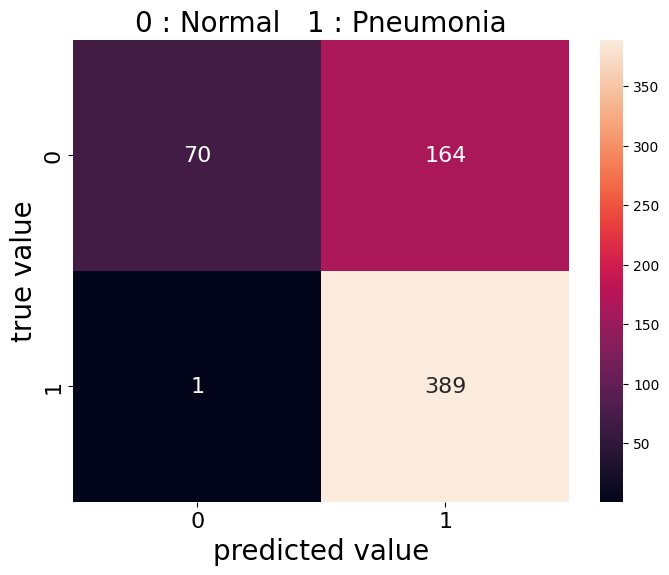

In [34]:
conf_matrix_test = confusion_matrix(y_test,y_pred_test)
print(conf_matrix_test)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_test, square=False, annot=True, fmt ='d', cbar=True, annot_kws={"size": 16})
plt.title('0 : Normal   1 : Pneumonia', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('predicted value', fontsize = 20)
plt.ylabel('true value', fontsize = 20)
plt.show()

In [35]:
# Calculate Precision and Recall
tn, fp, fn, tp = conf_matrix_test.ravel()
print('tn = {}, fp = {}, fn = {}, tp = {} '.format(tn, fp, fn, tp))

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp+tn)/(tp+tn+fp+fn)
f1_score = 2. * precision * recall / (precision + recall)
f2_score = 5. * precision * recall / (4. * precision + recall)

print("\nTest Recall of the model \t = {:.4f}".format(recall))
print("\nTest Precision of the model \t = {:.4f}".format(precision))
print("\nTest Accuracy of the model \t = {:.4f}".format(accuracy))
print("\nTest F1 score of the model \t = {:.4f}".format(f1_score))
print("\nTest F2 score of the model \t = {:.4f}".format(f2_score))

tn = 70, fp = 164, fn = 1, tp = 389 

Test Recall of the model 	 = 0.9974

Test Precision of the model 	 = 0.7034

Test Accuracy of the model 	 = 0.7356

Test F1 score of the model 	 = 0.8250

Test F2 score of the model 	 = 0.9205


## KNN prediction semi-conclusion:
<span style="color:red"> High Recall may be accompanied by lower precision. In pneumonia detection case, the risk of false negatives is greater than false positives. False negatives can easily cause the spread of infectious diseases, lead to more serious harm, and bring higher social costs. Therefore, recall is more important than precision. However, if it is a low-infectious pneumonia, considering that medical resources are limited, low precision can easily cause a waste of medical resources, prioritizing a model with higher precision becomes crucial.</span>

# Gaussian Naive Bayes (Gaussian NB)

In [36]:
from sklearn.naive_bayes import GaussianNB

GNB_model = GaussianNB()
GNB_model.fit(x_train_reshape, y_train)

GaussianNB()

In [37]:
x_val, y_val = load_data(files_dir='/val')
x_val_reshape = x_val.reshape(x_val.shape[0], -1)
ypred_val = GNB_model.predict(x_val_reshape)

Total number of images:  (16, 224, 224, 3)
Total number of labels:  (16,)


In [38]:
# Load test dataset
x_test, y_test = load_data(files_dir='/test')
x_test_reshape = x_test.reshape(x_test.shape[0], -1)
ypred = GNB_model.predict(x_test_reshape) 

Total number of images:  (624, 224, 224, 3)
Total number of labels:  (624,)


In [39]:
accuracy_val = accuracy_score(y_val, y_pred_val)
conf_matrix_val = confusion_matrix(y_val, y_pred_val)
classification_rep_val = classification_report(y_val, y_pred_val)
print("Validation:")
print(f"Accuracy: {accuracy_val}")
print("Confusion Matrix:")
print(conf_matrix_val)

Validation:
Accuracy: 0.5
Confusion Matrix:
[[0 8]
 [0 8]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,ypred) #計算準確率

0.7275641025641025

[[ 70 164]
 [  1 389]]


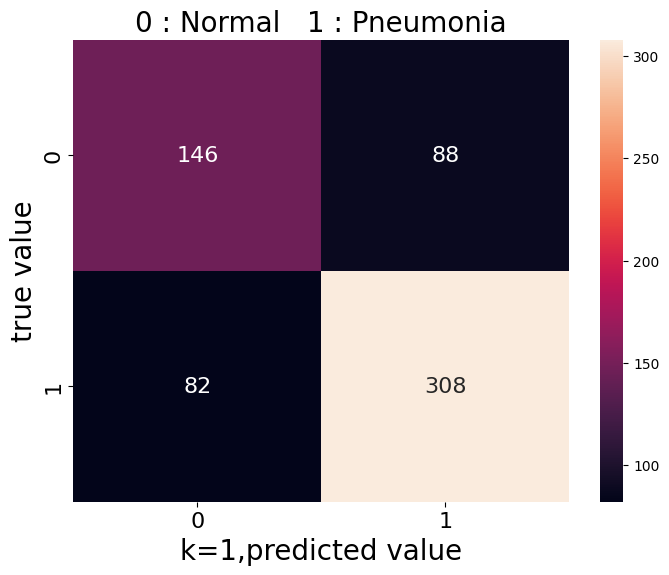

In [41]:
mat = confusion_matrix(y_test,ypred)
print(conf_matrix_test)

plt.figure(figsize=(8,6))
sns.heatmap(mat, square=False, annot=True, fmt ='d', cbar=True, annot_kws={"size": 16})
plt.title('0 : Normal   1 : Pneumonia', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('k=1,predicted value', fontsize = 20)
plt.ylabel('true value', fontsize = 20)
plt.show()

In [42]:
# Calculate Precision and Recall
tn, fp, fn, tp = mat.ravel()
print('tn = {}, fp = {}, fn = {}, tp = {} '.format(tn, fp, fn, tp))

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp+tn)/(tp+tn+fp+fn)
f1_score = 2. * precision * recall / (precision + recall)
f2_score = 5. * precision * recall / (4. * precision + recall)

print("\nTest Recall of the model \t = {:.4f}".format(recall))
print("\nTest Precision of the model \t = {:.4f}".format(precision))
print("\nTest Accuracy of the model \t = {:.4f}".format(accuracy))
print("\nTest F1 score of the model \t = {:.4f}".format(f1_score))
print("\nTest F2 score of the model \t = {:.4f}".format(f2_score))

tn = 146, fp = 88, fn = 82, tp = 308 

Test Recall of the model 	 = 0.7897

Test Precision of the model 	 = 0.7778

Test Accuracy of the model 	 = 0.7276

Test F1 score of the model 	 = 0.7837

Test F2 score of the model 	 = 0.7873


## Gaussian NB prediction semi-conclusion: 

<span style="color:red">The model is not good enough</span>

# Decision Trees Classifier

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree



# Create Decision Tree model
DT_model = DecisionTreeClassifier()





In [44]:
# Load test dataset
#x_test, y_test = load_data(files_dir='/test')

# Reshape test data
#x_test_reshape = x_test.reshape(x_test.shape[0], -1)

#x_train, y_train = load_data(files_dir='/train')

#x_train_reshape = x_train.reshape(x_train.shape[0], -1)

In [45]:
# Fit the model
DT_model.fit(x_train_reshape, y_train)
# Predict using the trained Decision Tree model
y_pred = DT_model.predict(x_test_reshape)

In [46]:
import graphviz 
dot_data = tree.export_graphviz(DT_model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("DT")
graph.view()

'DT.pdf'

In [47]:
accuracy_score(y_test,y_pred)

0.7275641025641025

Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'DT.pdf'


[[ 70 164]
 [  1 389]]


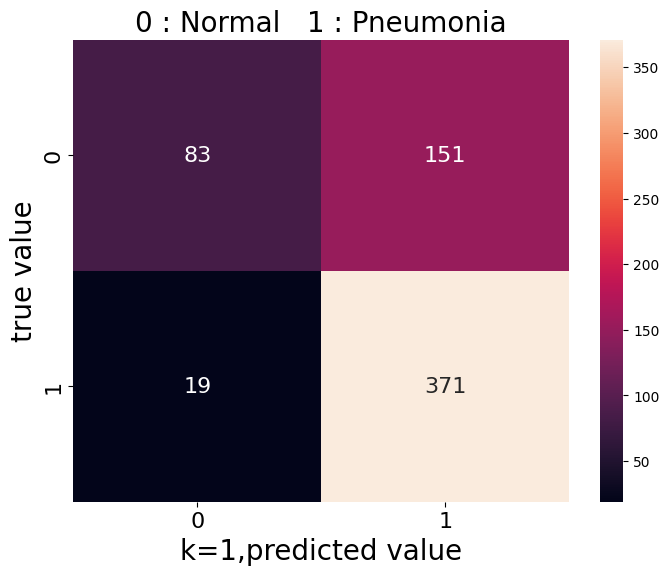

In [48]:
mat = confusion_matrix(y_test,y_pred)
print(conf_matrix_test)

plt.figure(figsize=(8,6))
sns.heatmap(mat, square=False, annot=True, fmt ='d', cbar=True, annot_kws={"size": 16})
plt.title('0 : Normal   1 : Pneumonia', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('k=1,predicted value', fontsize = 20)
plt.ylabel('true value', fontsize = 20)
plt.show()

In [49]:
# Calculate Precision and Recall
tn, fp, fn, tp = mat.ravel()
print('tn = {}, fp = {}, fn = {}, tp = {} '.format(tn, fp, fn, tp))

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp+tn)/(tp+tn+fp+fn)
f1_score = 2. * precision * recall / (precision + recall)
f2_score = 5. * precision * recall / (4. * precision + recall)

print("\nTest Recall of the model \t = {:.4f}".format(recall))
print("\nTest Precision of the model \t = {:.4f}".format(precision))
print("\nTest Accuracy of the model \t = {:.4f}".format(accuracy))
print("\nTest F1 score of the model \t = {:.4f}".format(f1_score))
print("\nTest F2 score of the model \t = {:.4f}".format(f2_score))

tn = 83, fp = 151, fn = 19, tp = 371 

Test Recall of the model 	 = 0.9513

Test Precision of the model 	 = 0.7107

Test Accuracy of the model 	 = 0.7276

Test F1 score of the model 	 = 0.8136

Test F2 score of the model 	 = 0.8910


In [50]:
classification_rep_test = classification_report(y_test, y_pred)
print(classification_rep_test)

              precision    recall  f1-score   support

           0       0.81      0.35      0.49       234
           1       0.71      0.95      0.81       390

    accuracy                           0.73       624
   macro avg       0.76      0.65      0.65       624
weighted avg       0.75      0.73      0.69       624



## Conclucion of Decision Trees Classifier :

It is not a good model of Pneumonia detection , 